# Getting Intimate with MNIST

The MNIST database found [here](http://yann.lecun.com/exdb/mnist/) from Yann LeCun et friends. 

It is a collection of 70,000 handwritten numbers as greyscale images of size $28$ by $28$. This database is by far the most popular in machine learning publications, it is a good means by which to benchmark an algorithm or model architecture. Furthermore, the simplicity of the problem allows for reasonable training times whilst still achieving impressive results.

## Getting the MNIST data

Luckily the MNIST data is available through the keras framework. This is very convenient. 

In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


print('Training data shape: ', x_train.shape)
print('Testing data shape : ', x_test.shape)

Using TensorFlow backend.


Training data shape:  (60000, 28, 28)
Testing data shape :  (10000, 28, 28)


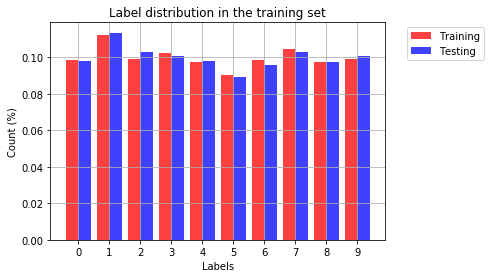

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

training_counts = [None] * 10 
testing_counts = [None] * 10
for i in range(10):
    training_counts[i] = len(y_train[y_train == i])/len(y_train)
    testing_counts[i] = len(y_test[y_test == i])/len(y_test)

# the histogram of the data
train_bar = plt.bar(np.arange(10)-0.2, training_counts, align='center', color = 'r', alpha=0.75, width = 0.41, label='Training')
test_bar = plt.bar(np.arange(10)+0.2, testing_counts, align='center', color = 'b', alpha=0.75, width = 0.41, label = 'Testing')

plt.xlabel('Labels')
plt.xticks((0,1,2,3,4,5,6,7,8,9))
plt.ylabel('Count (%)')
plt.title('Label distribution in the training set')
plt.legend(bbox_to_anchor=(1.05, 1), handles=[train_bar, test_bar], loc=2)
plt.grid(True)
plt.show()

## Printing MNIST images to the screen

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# utility function for showing images
def show_imgs(x_test, decoded_imgs=None, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

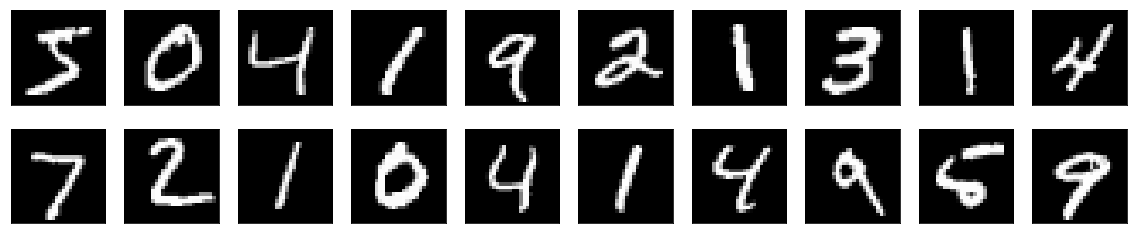

Training labels:  [5 0 4 1 9 2 1 3 1 4]
Testing labels :  [7 2 1 0 4 1 4 9 5 9]


In [4]:
show_imgs(x_train, x_test)
print('Training labels: ', y_train[0:10])
print('Testing labels : ', y_test[0:10])

## Classifying the MNIST dataset

We want the computer to be able to read these images and determine what number is written within its boundary. To do this we will use machine leanrning for the purpose of classification. The demonstrated success of neural network algorithms on this particular problem was the beginning of the pursuit for deep learning. Since that start, the underlying reasons as to why neural networks are particularly well suited for interpreting images has been demonstrated and extended to solve many more complex problems. 

The 

Generally, this means going from a feature-set, the MNIST images, and mapping that input to an output, the value of the number. 

Classification pertains to going from a set of features and determining which is the most likely 

### Keras implementation

In [14]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

Prepare the data to be used in the model. We need to reshape the inputs and outputs such that their channel is their last dimension.

Furthermore, the outputs are converted to 1-hot encoding. This means that a vector index coinciding with the class is set high to indicate a certain label.

<br>
<center>
$0 = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]$ <br>
$1 = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]$ <br>
$...$ <br>
$9 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]$ <br>
    </center>

In [10]:
# The known number of output classes.
num_classes = 10

# Input image dimensions
img_rows, img_cols = 28, 28

# Channels go last for TensorFlow backend
x_train_reshaped = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# Convert class vectors to binary class matrices. This uses 1 hot encoding.
y_train_binary = keras.utils.to_categorical(y_train, num_classes)
y_test_binary = keras.utils.to_categorical(y_test, num_classes)

Design a sequential model in Keras describing your architecture.

We are using:
- **Convolution:** 32, 3x3 filters with rectifier linear unit
- **Convolution:** 64, 3x3 filters with rectifier linear unit
- **Max Pooling:** 2x2 pool size
- **Dropout:** drop 25% of the tensor
- **Dense:** 128 fully connected nodes using rectifier linear unit
- **Dropout:** drop 50% of the tensor
- **Dense:** output has 10 nodes using softmax activation

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Save the model, and set up a callback such that at every epoch the weights are saved to the disk. Then we fit the weights to our model.

In [13]:
# Save the model
model_json = model.to_json()
with open("weights/model.json", "w") as json_file:
    json_file.write(model_json)

# Save the weights using a checkpoint.
filepath="weights/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

epochs = 4
batch_size = 128
# Fit the model weights.
model.fit(x_train_reshaped, y_train_binary,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_data=(x_test_reshaped, y_test_binary))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 189s 3ms/step - loss: 0.1154 - acc: 0.9650 - val_loss: 0.0522 - val_acc: 0.9839
Epoch 2/4
60000/60000 [==============================] - 203s 3ms/step - loss: 0.0865 - acc: 0.9742 - val_loss: 0.0449 - val_acc: 0.9856
Epoch 3/4
60000/60000 [==============================] - 193s 3ms/step - loss: 0.0718 - acc: 0.9785 - val_loss: 0.0404 - val_acc: 0.9872
Epoch 4/4
60000/60000 [==============================] - 201s 3ms/step - loss: 0.0652 - acc: 0.9817 - val_loss: 0.0353 - val_acc: 0.9878


In [16]:
score = model.evaluate(x_test_reshaped, y_test_binary, verbose=0)
print('Model accuracy:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model accuracy:
Test loss: 0.0353407959812
Test accuracy: 0.9878


Predict the classes: 
10/10 [==============================] - 0s 3ms/step


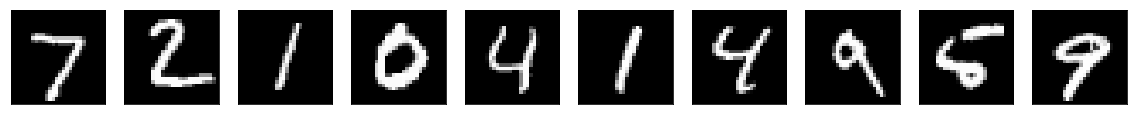

Predicted classes:  [7 2 1 0 4 1 4 9 5 9]


In [17]:
print('Predict the classes: ')
prediction = model.predict_classes(x_test_reshaped[0:10])
show_imgs(x_test)
print('Predicted classes: ', prediction)

### Load an existing model

Loaded model from disk


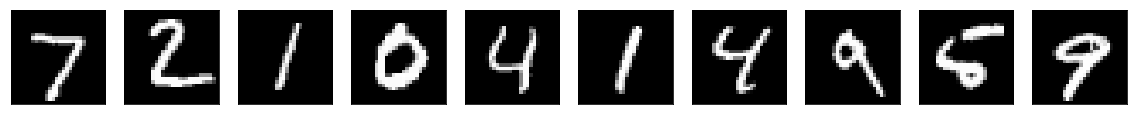

Predicted classes:  [7 2 1 0 4 1 4 9 5 9]


In [36]:
# load model saved as a json and create model
json_file = open('weights/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("weights/weights-improvement-04-0.99.hdf5")
print("Loaded model from disk")

# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
predictions = loaded_model.predict_classes(x_test_reshaped[0:10], verbose=0)
show_imgs(x_test[0:10])
print('Predicted classes: ', predictions)

In [37]:
loaded_model.summary()

loaded_model.get_config()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

[{'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 28, 28, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'dtype': 'float32',
   'filters': 32,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': (3, 3),
   'name': 'conv2d_3',
   'padding': 'valid',
   'strides': (1, 1),
   'trainable': True,
   'use_bias': True}},
 {'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),

## Autoencoder

### Learning a minimal feature set from which images can be recovered

An autoencoder can be used to extract features, we will build a symmetric network where the center is a constrained set of neurons. We will then train the network by feeding it the MNIST images and tuning the model's parameters to obtain a reconstruction of the original image at the output. If this results in a sufficiently good reconstruction, we can then determine that the features extracted by the constrained hidden layer can adequately represent the MNIST image. 

The information entropy in the constrained set is much higher than the input space, thus these features can be used for small data classification problems. 

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras import backend as K

In [ ]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x) #Test
encoded = Dense(128)(x) # Test
#encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Dense(128)(encoded)
x = Reshape((4,4,8))(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

In [ ]:
from keras.callbacks import TensorBoard
epochs = 50
batch_size = 128

autoencoder.fit(x_train_reshaped, x_train_reshaped, epochs=epochs, batch_size=batch_size,
               shuffle=True, validation_data=(x_test_reshaped, x_test_reshaped), verbose=1,
               callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [ ]:
decoded_imgs = autoencoder.predict(x_test_reshaped)
print("input (upper row)\ndecoded (bottom row)")
show_imgs(x_test_reshaped, decoded_imgs)

### Denoising autoencoder

This technique can lead to trivial solutions in the constrained layer. Thus, it is proposed to use a noisy version of the images to train the autoencoder. 